In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00


In [2]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("permutation", random.sample, range(8), 8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.permutation)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#fitness function taken from:
#https://github.com/LuisAlejandroSalcedo/Problema-de-las-N-Reinas/blob/master/NQueens.py
def fitness(individual):
    size = len(individual)

    #solo ataques en diagonal
    diagonal_izquierda_derecha = [0] * (2*size-1)
    diagonal_derecha_izquierda = [0] * (2*size-1)

    #no. de 1s en casa diago
    for i in range(size): # recorremos las columnas
        diagonal_izquierda_derecha[i+individual[i]] += 1 # [columna + fila]
        diagonal_derecha_izquierda[size-1-i+individual[i]] += 1 # [size-1-columna+ fila]

    suma = 0
    for i in range(2*size-1): # recorremos todas las diagonales
        if diagonal_izquierda_derecha[i] > 1: # hay ataques
            suma += diagonal_izquierda_derecha[i] - 1 # n-1 ataques
        if diagonal_derecha_izquierda[i] > 1:
            suma += diagonal_derecha_izquierda[i] - 1
    return suma,

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=2.0/8)
toolbox.register("select", tools.selTournament, tournsize=3)

In [16]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

def similar(ind1, ind2):
    """
    A custom similarity function that compares two individuals
    element-wise and returns True if they are identical, False otherwise.
    """
    return np.array_equal(ind1, ind2) # Use NumPy's array_equal for element-wise comparison

def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]
    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring

def ea(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
  logbook = tools.Logbook()
  logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

  # Evaluate the individuals with an invalid fitness
  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

  if halloffame is not None:
      halloffame.update(population)

  record = stats.compile(population) if stats else {}
  logbook.record(gen=0, nevals=len(invalid_ind), **record)
  if verbose:
      print(logbook.stream)

  # Begin the generational process
  for gen in range(1, ngen + 1):
      best = tools.selBest(population, 1)[0]
      #if best.fitness.values == (0,):
      #    break
      # Select the next generation individuals
      offspring = toolbox.select(population, len(population))

      # Vary the pool of individuals
      offspring = varAnd(offspring, toolbox, cxpb, mutpb)

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit

      # Update the hall of fame with the generated individuals
      if halloffame is not None:
          halloffame.update(offspring)

      # Replace the current population by the offspring
      population[:] = offspring

      # Append the current generation statistics to the logbook
      record = stats.compile(population) if stats else {}
      logbook.record(gen=gen, nevals=len(invalid_ind), **record)
      if verbose:
          print(logbook.stream)

  return population, logbook

In [18]:
pop = toolbox.population(n=10)
hof = tools.HallOfFame(10)
# Overwrite the default `similar` method in the HallOfFame class
hof.similar = similar
pop, log = ea(pop, toolbox, 0.5, 0.5, 90, stats=stats,
              halloffame=hof, verbose=True)

gen	nevals	avg	std    	min	max
0  	10    	3.5	1.11803	2  	6  
1  	8     	3.8	0.748331	3  	5  
2  	6     	3.2	0.6     	2  	4  
3  	5     	3  	1       	1  	5  
4  	10    	3.2	0.748331	2  	5  
5  	7     	3.8	1.07703 	2  	5  
6  	8     	3.3	0.458258	3  	4  
7  	6     	3.4	0.916515	3  	6  
8  	7     	3  	0.447214	2  	4  
9  	4     	3  	0.894427	2  	5  
10 	6     	2.8	0.979796	2  	5  
11 	8     	3.5	1.11803 	2  	5  
12 	9     	3.5	0.806226	3  	5  
13 	8     	3.6	0.8     	2  	5  
14 	6     	3.3	1.00499 	2  	5  
15 	6     	2.9	1.04403 	2  	5  
16 	10    	3.5	1.56525 	2  	6  
17 	9     	3.1	1.22066 	2  	6  
18 	6     	2.7	1.18743 	1  	5  
19 	7     	3.4	1.11355 	2  	5  
20 	7     	3.4	1.28062 	2  	5  
21 	6     	2.8	0.87178 	2  	4  
22 	5     	2.5	0.67082 	2  	4  
23 	7     	2.6	1.2     	2  	6  
24 	6     	2.7	0.9     	2  	4  
25 	9     	2.7	1.00499 	2  	5  
26 	10    	2.9	1.04403 	2  	5  
27 	8     	2.9	0.830662	2  	4  
28 	8     	2.9	1.13578 	1  	5  
29 	5     	2.7	1.48661 	1  	5  
30 	6     

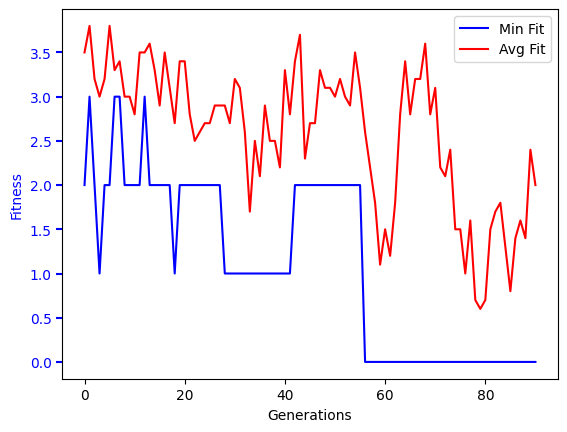

In [19]:
def convergence_graph(logbook, name):
  gen=logbook.select("gen")
  fit_max=logbook.select("min")
  fit_avg=logbook.select("avg")
  fig, host = plt.subplots()
  p1, = host.plot(gen, fit_max, "b-", label="Min Fit")
  p2, = host.plot(gen, fit_avg, "r-", label="Avg Fit")
  host.set_xlabel("Generations")
  host.set_ylabel("Fitness")
  host.yaxis.label.set_color(p1.get_color())
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='y', colors=p1.get_color(), **tkw)
  lines = [p1,p2]

  host.legend(lines, [l.get_label() for l in lines], loc="upper right")
  # fig.savefig(ruta+"/Convergencia.png")
  fig.savefig("./"+name)
  # plt.close(fig)
  plt.show()

convergence_graph(log, "GraficaConvergencia")

[7 3 0 2 5 1 6 4]


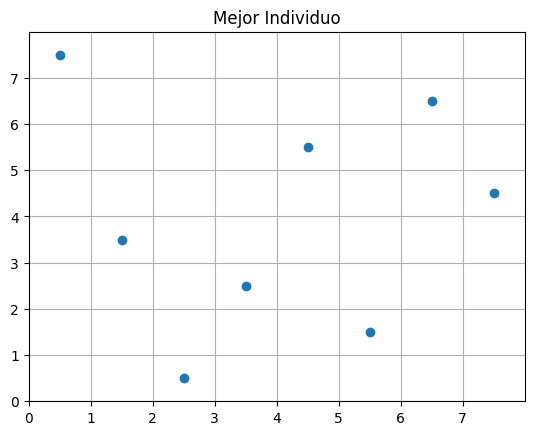

In [20]:
import matplotlib.pyplot as plt
best = tools.selBest(pop, 1)[0]
print(str(best))
x= range(8)
x= np.array(x)
y=best
y = np.array(y)
x = x + 0.5
y = y + 0.5
plt.figure()
plt.scatter(x,y)
plt.xlim(0,8)
plt.ylim(0,8)
plt.xticks(x-0.5)
plt.yticks(x-0.5)
plt.grid(True)
plt.title(u"Mejor Individuo")
plt.show()